In [1]:
import numpy as np
import pandas as pd
from defillama2 import DefiLlama
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../'
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

## Get Prices and Calculate BTC/ETH

In [3]:
obj = DefiLlama()

In [4]:
dd = {'0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599':'ethereum',
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2':'ethereum',
      'ethereum':'coingecko',
      }

In [6]:
df = obj.get_tokens_hist_prices(dd, start='2022-01-01', end='2022-11-05', type='open')
df.head()

,ETH,WBTC,WETH
date,,,
2022-01-01,"3,680.8989","46,321.3776","3,680.4088"
2022-01-02,"3,781.8073","47,765.5573","3,771.4037"
2022-01-03,"3,833.8640","47,370.4536","3,830.8752"
2022-01-04,"3,769.4049","46,517.2254","3,765.4482"
2022-01-05,"3,794.9081","45,914.5021","3,801.7617"


In [7]:
xs = df.WETH.where(~df.WETH.isna(), df.ETH) # replace NaNs in WETH with ETH
df['BTCETH'] = df.WBTC / xs
df.tail()

,ETH,WBTC,WETH,BTCETH
date,,,,
2022-11-01,"1,572.9795","20,488.0000","1,573.1800",13.0233
2022-11-02,"1,580.3787","20,478.0000","1,583.3700",12.9332
2022-11-03,"1,520.6384","20,141.0000","1,518.9300",13.2600
2022-11-04,"1,531.6944","20,220.0000","1,531.4539",13.2031
2022-11-05,"1,644.4788","21,157.1414","1,644.9245",12.8621


## Find Q1 and Q3 values of BTC/ETH for different start dates

In [8]:
dat = df.drop(['ETH', 'WBTC', 'WETH'], axis=1)

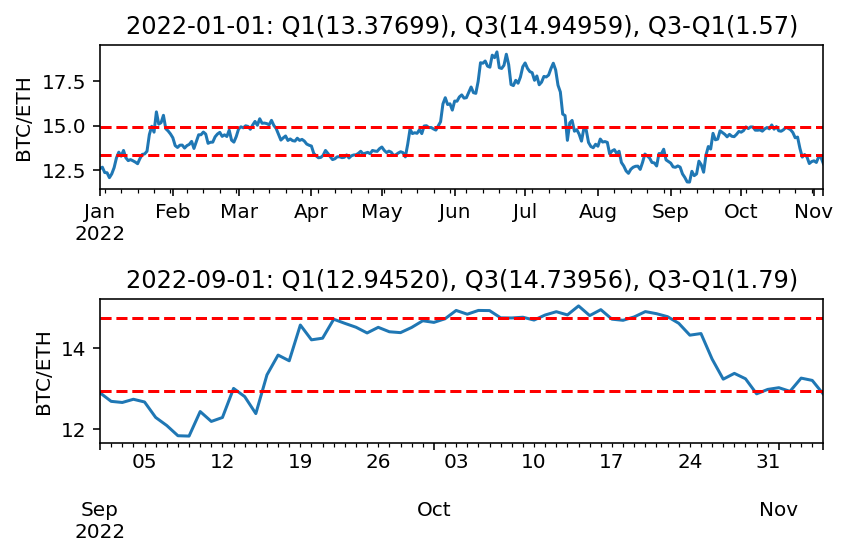

In [9]:
start_dates = ['2022-01-01', '2022-09-01',]
fig, axes = plt.subplots(len(start_dates),1)
for i in range(len(start_dates)):
    start = start_dates[i]
    subdf = dat[start:]
    q1 = subdf.quantile(0.25)[0]
    q3 = subdf.quantile(0.75)[0]

    # plot
    mon = subdf.index[0].month_name()
    subdf.plot(legend=False, xlabel='', ylabel='BTC/ETH', ax=axes[i],
               title="{}: Q1({:0.5f}), Q3({:0.5f}), Q3-Q1({:0.2f})".format(start, q1, q3, q3-q1))
    axes[i].axhline(y=q1, color='red', linestyle='--')
    axes[i].axhline(y=q3, color='red', linestyle='--');
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH price range by start date.png'), dpi=300)    

## Find monthly Q1 and Q3 values for BTC/ETH

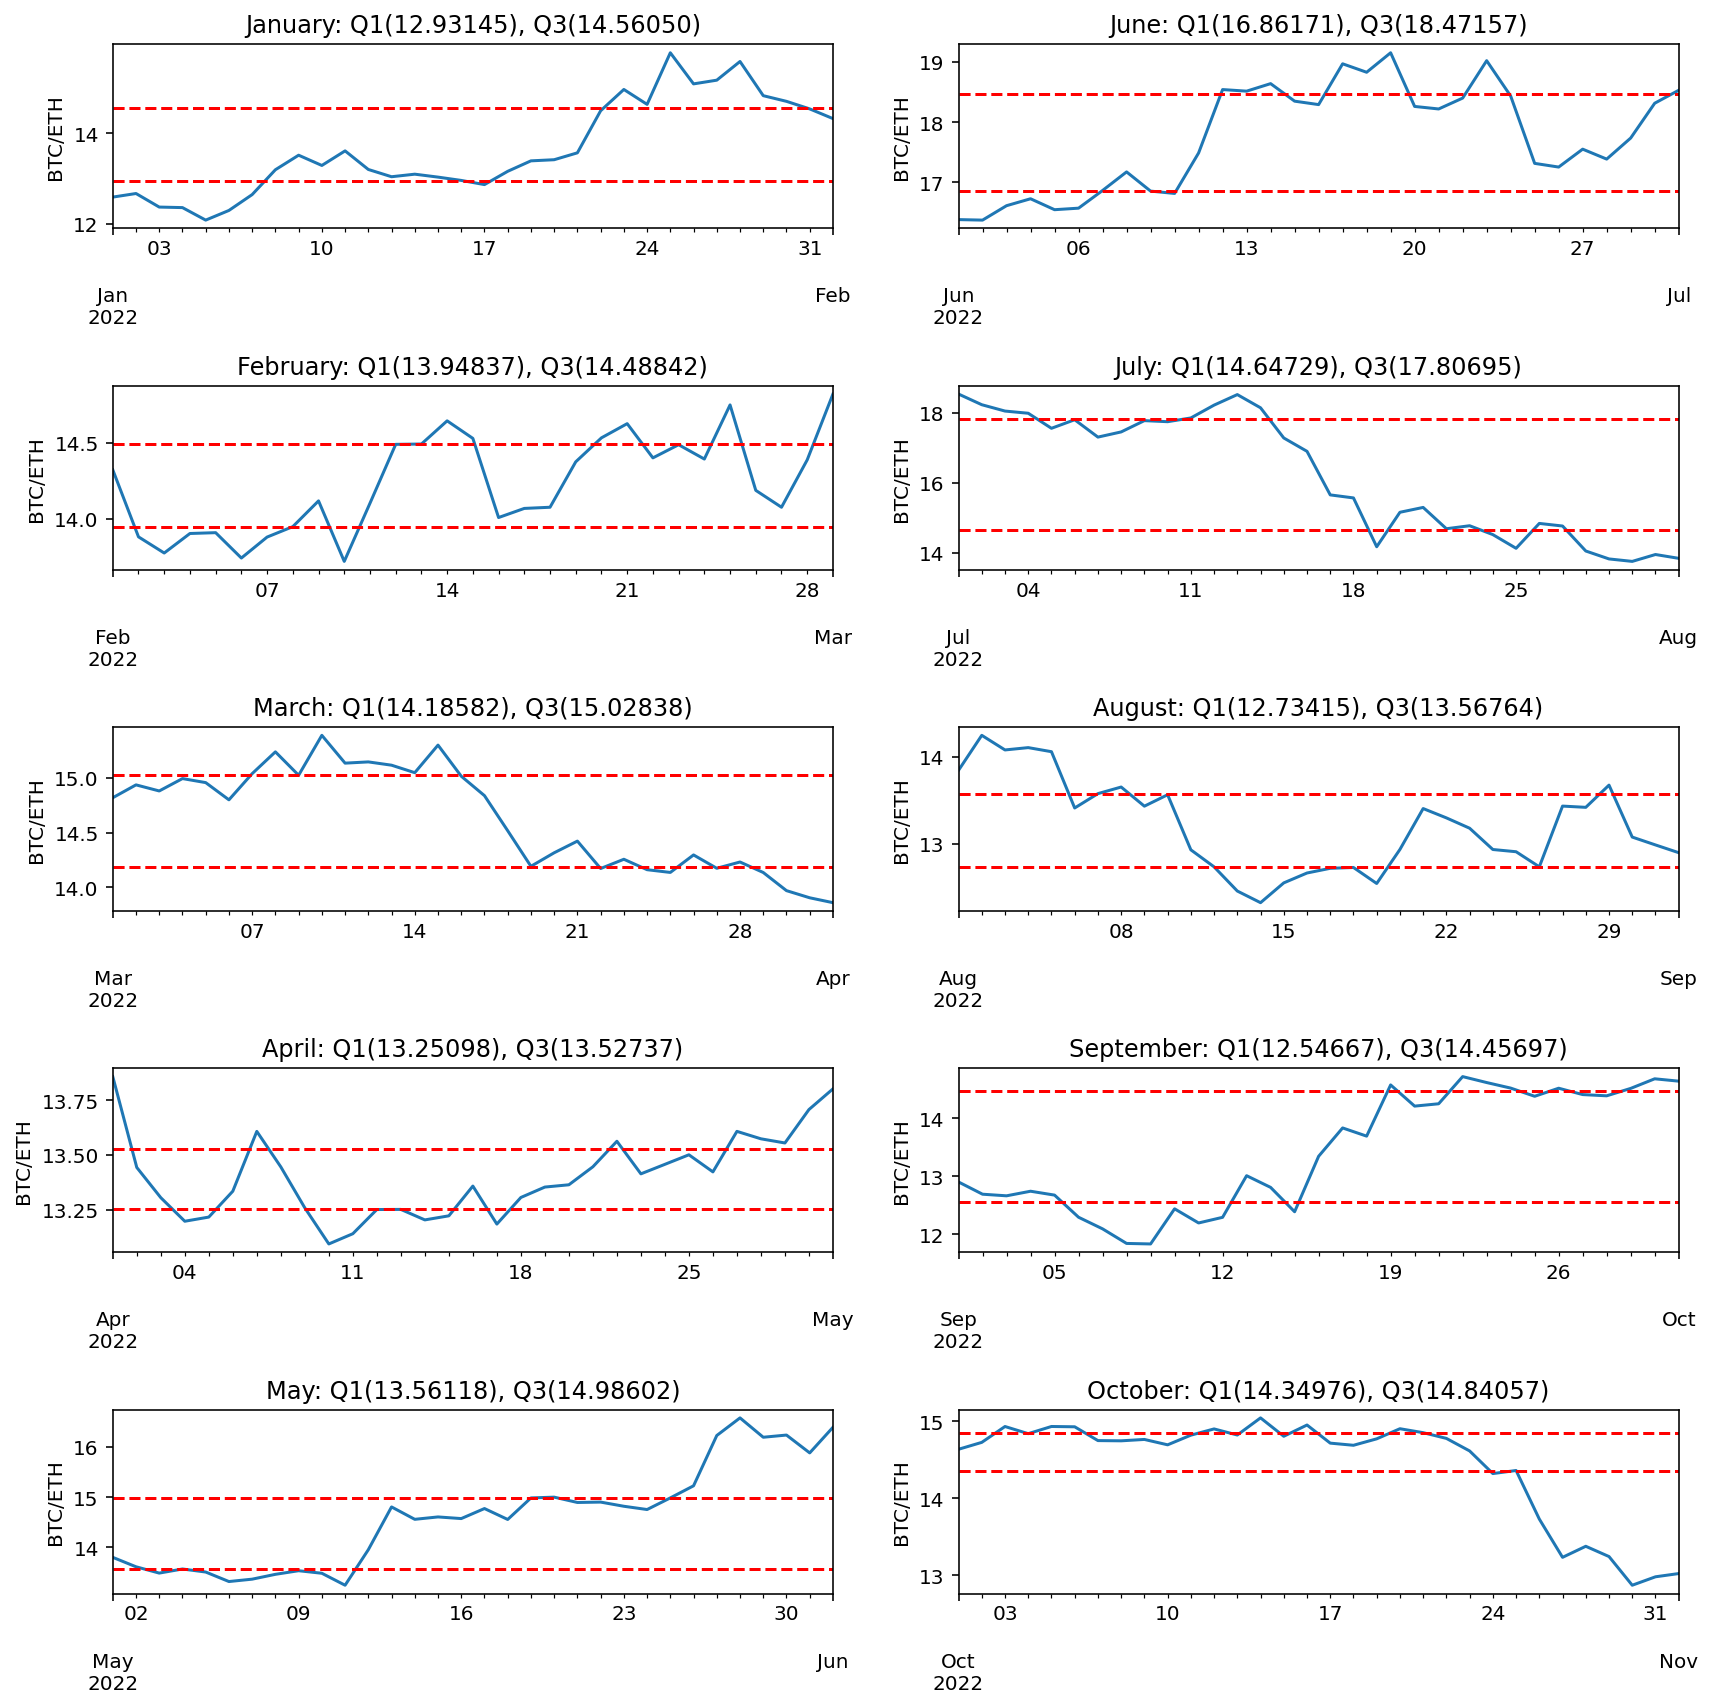

In [10]:
start_dates = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01']
end_dates = ['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', 
             '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01']

q1s = []
q3s = []
fig, axes = plt.subplots(5,2, figsize=(12,12))
for i in range(len(start_dates)):
    start = start_dates[i]
    end = end_dates[i]
    subdf = dat[start:end]
    q1 = subdf.quantile(0.25)[0]
    q3 = subdf.quantile(0.75)[0]
    q1s.append(q1)
    q3s.append(q3)
    
    # plot
    mon = subdf.index[0].month_name()
    j = 0 if i < 5 else 1
    subdf.plot(legend=False, xlabel='', ylabel='BTC/ETH', ax=axes[i%5,j],
               title="{}: Q1({:0.5f}), Q3({:0.5f})".format(mon, q1, q3))
    axes[i%5,j].axhline(y=q1, color='red', linestyle='--')
    axes[i%5,j].axhline(y=q3, color='red', linestyle='--');   
plt.tight_layout()    
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH price range by month.png'), dpi=300)        

In [11]:
df_qtrs = pd.DataFrame({"Q1":q1s, "Q3":q3s})
df_qtrs['Q3-Q1'] = df_qtrs.Q3 - df_qtrs.Q1

In [12]:
df_qtrs

,Q1,Q3,Q3-Q1
0,12.9314,14.5605,1.6291
1,13.9484,14.4884,0.5401
2,14.1858,15.0284,0.8426
3,13.2510,13.5274,0.2764
4,13.5612,14.9860,1.4248
5,16.8617,18.4716,1.6099
6,14.6473,17.8070,3.1597
7,12.7342,13.5676,0.8335
8,12.5467,14.4570,1.9103
9,14.3498,14.8406,0.4908


In [13]:
# very conservative 
df_qtrs.Q1.min(), df_qtrs.Q3.max()

(12.546668137446316, 18.47157394696774)

In [14]:
# the middle way
df_qtrs.Q1.median(), df_qtrs.Q3.median()

(13.75477732303806, 14.700538814234953)

## Naive Forecast of BTC/ETH with fbprophet

In [15]:
future_days = 14 # forecast for the next 30 days

In [16]:
start = '2022-09-01' # only use recent data
subdf = dat[start:].reset_index()
subdf[['ds', 'y']] = subdf[['date', 'BTCETH']] # necessary for fbprophet
subdf.head()

,date,BTCETH,ds,y
0,2022-09-01,12.8972,2022-09-01,12.8972
1,2022-09-02,12.6863,2022-09-02,12.6863
2,2022-09-03,12.6587,2022-09-03,12.6587
3,2022-09-04,12.7378,2022-09-04,12.7378
4,2022-09-05,12.6708,2022-09-05,12.6708


In [17]:
from fbprophet import Prophet

model = Prophet() 
model.fit(subdf)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -29.9974


Iteration  1. Log joint probability =    66.9887. Improved by 96.9861.
Iteration  2. Log joint probability =    103.439. Improved by 36.4505.
Iteration  3. Log joint probability =    115.963. Improved by 12.5243.
Iteration  4. Log joint probability =     143.76. Improved by 27.7967.
Iteration  5. Log joint probability =     143.78. Improved by 0.0194082.
Iteration  6. Log joint probability =    143.814. Improved by 0.0340168.
Iteration  7. Log joint probability =     143.87. Improved by 0.0560297.
Iteration  8. Log joint probability =    143.977. Improved by 0.107451.
Iteration  9. Log joint probability =    144.123. Improved by 0.145471.
Iteration 10. Log joint probability =    144.621. Improved by 0.49865.
Iteration 11. Log joint probability =     144.67. Improved by 0.0493013.
Iteration 12. Log joint probability =    144.862. Improved by 0.191613.
Iteration 13. Log joint probability =    145.005. Improved by 0.142765.
Iteration 14. Log joint probability =    145.038. Improved by 0.0

In [18]:
future = model.make_future_dataframe(periods=future_days)
forecast = model.predict(future)
forecast.head()

/usr/local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-09-01,12.0067,11.4775,12.4950,12.0067,12.0067,-0.0174,...,-0.0174,-0.0174,-0.0174,0.0000,0.0000,0.0000,11.9894
1,2022-09-02,12.1021,11.6682,12.6276,12.1021,12.1021,0.0584,...,0.0584,0.0584,0.0584,0.0000,0.0000,0.0000,12.1605
2,2022-09-03,12.1975,11.7558,12.7232,12.1975,12.1975,0.0626,...,0.0626,0.0626,0.0626,0.0000,0.0000,0.0000,12.2601
3,2022-09-04,12.2929,11.7597,12.7539,12.2929,12.2929,-0.0403,...,-0.0403,-0.0403,-0.0403,0.0000,0.0000,0.0000,12.2526
4,2022-09-05,12.3883,11.9208,12.9465,12.3883,12.3883,0.0271,...,0.0271,0.0271,0.0271,0.0000,0.0000,0.0000,12.4154


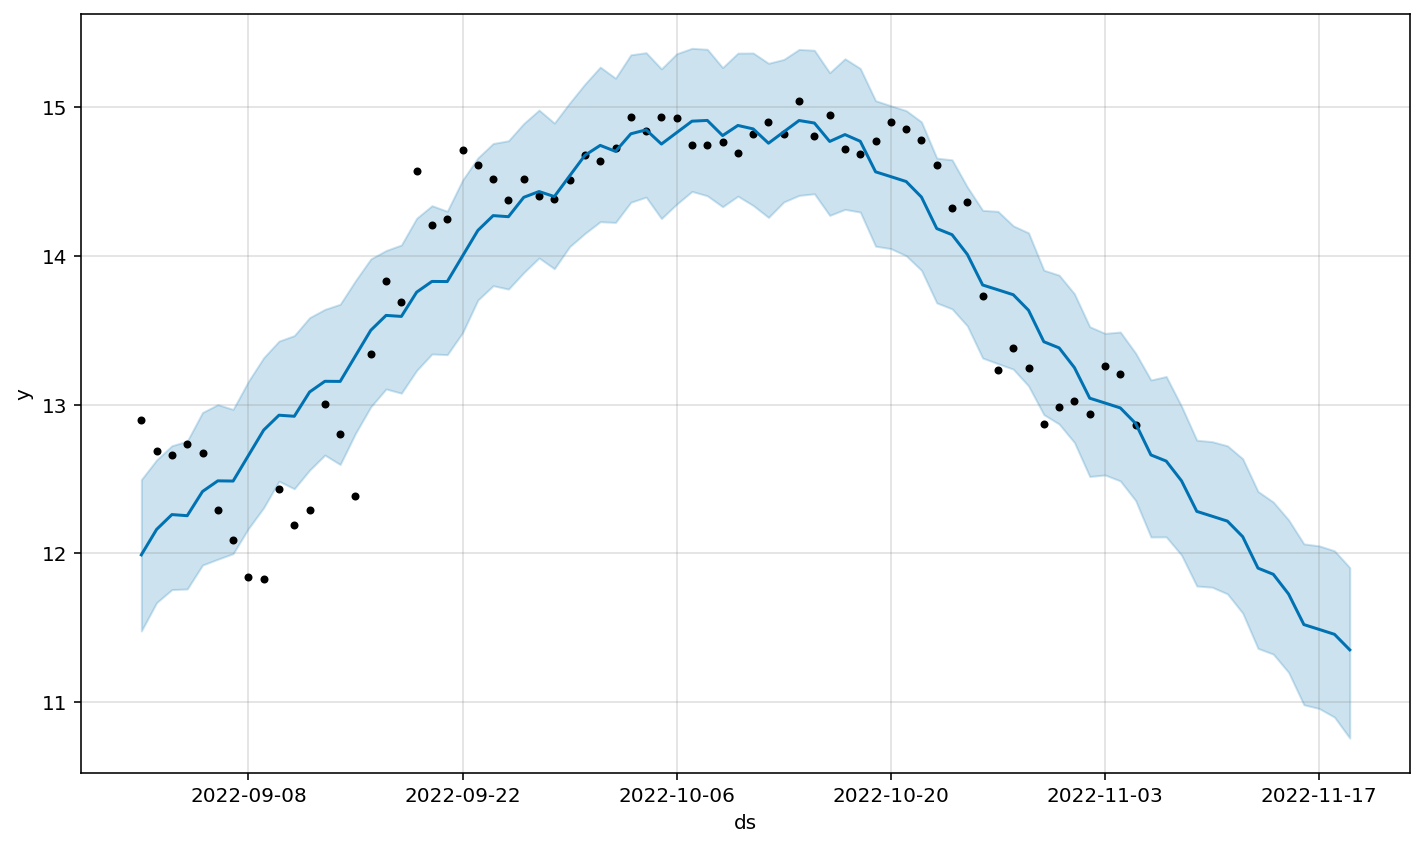

In [19]:
model.plot(forecast)
plt.show()

In [20]:
df_fut = forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].iloc[-future_days:,].set_index('ds')

In [21]:
df_fut.yhat.min(), df_fut.yhat.max(),

(11.350546182505534, 12.661041519926348)

In [22]:
df_fut.yhat_lower.min(), df_fut.yhat_upper.max(),

(10.757337590403633, 13.188518167885341)